# Практическое задание по теме 6. Данные в страховом бизнесе. 
## EDA

In [1]:
import numpy as np
import pandas as pd 
import random

import statsmodels.api as sm

from datetime import datetime, date
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.feature_selection import SelectKBest, SelectPercentile, SelectFromModel
from sklearn.feature_selection import f_regression, mutual_info_regression

from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import scipy.stats as st

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

### Задание
На основе датасета из ноутбука проведите анализ данных и постройте зависимости частоты и среднего убытка от какого-либо параметра (за исключением уже выполненных в ноутбуке).

### 1. Обзор обучающего датасета <a name = 'data'></a>

#### Описание датасета

* __Exposure__ - выраженный в годах срок действия договора страхования в отчетном периоде (0.001 - 1)
* __LicAge__ - водительский стаж
* __RecordBeg__ - дата начала действия страхового договора - текущий год
* __RecordEnd__ - дата окончания действия страхового договора в текущем году
* __VehAge__ - возраст транспортного средства
* __Gender__ - пол водителя
* __MariStat__ - семейное положение
* __SocioCateg__ - социальная категория
* __VehUsage__ - использование транспортного средства (в частных целях, в частных целях плюс поездки до офиса, профессиональное использование, профессиональный извоз)
* __DrivAge__ - возраст водителя
* __HasKmLimit__ - наличие/отстутсвие лимита по киллометражу
* __BonusMalus__ - бонусные баллы от 50 до 272
* __VehBody__ - тип транспотного средства (седан, кабриолет, автобус, микроавтобус и т.д)
* __VehPrice__ - код цены транспортного средства
* __VehEngine__ - тип двигателя (электрический, карбюраторный, инжекторный, газовый и т.д.)
* __VehEnergy__ - тип топлива транспортного средства (обычное, дизельное, электрическое, газовое)
* __VehMaxSpeed__ - максимальная скорость транспортного средства
* __VehClass__ - код класса транспортного средства
* __ClaimAmount__ - сумма страховго возмещения
* __RiskVar__ - оценка риска по 20-балльной шкале
* __Garage__ - отсутсвие гаража, частный гараж, коллективный гараж
* __ClaimInd__ - наличие/ отсутствие страховых случаев
* __Dataset__ - индекс датасета (1-10)
* __DeducType__ - тип скидки 
* __ClaimNbResp__ - оценка ClaimNbResp по 5-балльной шкале (0-5)
* __ClaimNbNonResp__ - оценка ClaimNbNonResp по 7-балльной шкале (0-7)
* __ClaimNbParking__ - оценка ClaimNbParking (парковка) по 5-балльной шкале (0-5)
* __ClaimNbFireTheft__ оценка ClaimNbFireTheft (пожар, воровство) по 4-балльной шкале (0-4)
* __ClaimNbWindscreen__ оценка ClaimNbWindscreen (ветровое стекло) по 8-балльной шкале (0-8)
* __OutUseNb__ оценка OutUseNb по 5-балльной шкале (0-5)
* __RiskArea__ - оценка RiskArea по 13-балльной шкале (1-13)

#### Пути к директориям и файлам

In [3]:
PATH = 'C:/Users/ASER/Desktop/GeekBrains/ML_in_business/Lesson_6/'
TRAIN_DATASET_PATH = PATH + 'freMPL-R.csv'

### 2. Загрузка данных <a name = 'load_data'></a>

In [4]:
data = pd.read_csv(TRAIN_DATASET_PATH, parse_dates=[2, 3])
print(data.shape)
data.head(2)

(343080, 31)


Exposure  LicAge  RecordBeg RecordEnd VehAge  Gender MariStat SocioCateg  \
0     0.583     366 2004-06-01       NaT      2  Female    Other       CSP1   
1     0.200     187 2004-10-19       NaT      0    Male    Alone      CSP55   

                 VehUsage  DrivAge  ...  ClaimInd  Dataset DeducType  \
0            Professional       55  ...         0        1       NaN   
1  Private+trip to office       34  ...         0        1       NaN   

  ClaimNbResp ClaimNbNonResp ClaimNbParking ClaimNbFireTheft  \
0         NaN            NaN            NaN              NaN   
1         NaN            NaN            NaN              NaN   

  ClaimNbWindscreen  OutUseNb  RiskArea  
0               NaN       NaN       NaN  
1               NaN       NaN       NaN  

[2 rows x 31 columns]

Не разбирать:

In [5]:
ANALYSED_FEATURE_NAMES = ['LicAge', 'Gender', 'MariStat', 'SocioCateg', 'DrivAge']

In [6]:
FEATURE_NAMES = []
for name in data.columns:
    if not name in ANALYSED_FEATURE_NAMES:
        FEATURE_NAMES.append(name)

### 3. Пропуски данных

In [7]:
len(data[FEATURE_NAMES]) - data[FEATURE_NAMES].count()

Exposure                  0
RecordBeg                 0
RecordEnd            161965
VehAge               165200
VehUsage                  0
HasKmLimit                0
BonusMalus                0
VehBody              197300
VehPrice             197300
VehEngine            197300
VehEnergy            197300
VehMaxSpeed          197300
VehClass             197300
ClaimAmount               0
RiskVar              197300
Garage               197300
ClaimInd                  0
Dataset                   0
DeducType            276190
ClaimNbResp          145780
ClaimNbNonResp       145780
ClaimNbParking       145780
ClaimNbFireTheft     145780
ClaimNbWindscreen    145780
OutUseNb             145780
RiskArea             145780
dtype: int64

### 2. Классификация признаков

In [8]:
df = data.copy()
df['PolicyCount'] = 1
df['ClaimCount'] = df['ClaimAmount'] > 0
df['NoClaimCount'] = df.PolicyCount - df.ClaimCount
df[['PolicyCount','ClaimAmount', 'ClaimCount', 'NoClaimCount']].head(2)

PolicyCount  ClaimAmount  ClaimCount  NoClaimCount
0            1          0.0       False             1
1            1          0.0       False             1

In [9]:
def plot_dependencies(df, var_name, levels=None): 
    fig, axes = plt.subplots(2, 1, figsize=(20, 10))
    
    df_group_var = df[['Exposure', 'PolicyCount','ClaimAmount', 'ClaimCount', 'NoClaimCount']].groupby(df[var_name]).sum()
    df_group_var = df_group_var.reset_index()

    df_group_var['Freq'] = df_group_var.ClaimCount / df_group_var.Exposure
    df_group_var['AvgClaim'] = df_group_var.ClaimAmount / df_group_var.ClaimCount 
    
    if levels:
        sns.barplot(x=levels, y=df_group_var['Freq'], palette="viridis", ax=axes[0])
        sns.barplot(x=levels, y=df_group_var['AvgClaim'], palette="viridis", ax=axes[1])
    else:
        sns.barplot(x=df_group_var[var_name], y=df_group_var['Freq'], palette="viridis", ax=axes[0])
        sns.barplot(x=df_group_var[var_name], y=df_group_var['AvgClaim'], palette="viridis", ax=axes[1])
    
    axes[0].set_title(f'Зависимость частоты убытков от {var_name}', size=14)
    axes[1].set_title(f'Зависимость среднего убытка от {var_name}', size=14)
    
    plt.show()

### 2. 1. Признаки, связанные со временем

In [10]:
TIME_FEATURE_NAMES = data[FEATURE_NAMES].select_dtypes(include=[np.datetime64]).columns.to_list()
data[TIME_FEATURE_NAMES].head()

RecordBeg  RecordEnd
0 2004-06-01        NaT
1 2004-10-19        NaT
2 2004-07-16 2004-08-16
3 2004-08-16        NaT
4 2004-01-01 2004-07-01

### 2.2 Количественные признаки

In [11]:
NUMERICAL_FEATURE_NAMES = data[FEATURE_NAMES].select_dtypes(include=[np.number]).columns.to_list()

#### 1. Дискретные признаки

In [12]:
DISCRETE_FEATURE_NAMES = [feature for feature in NUMERICAL_FEATURE_NAMES
                          if len(data[feature].unique()) < 25]

data[DISCRETE_FEATURE_NAMES].head(2)

HasKmLimit  RiskVar  ClaimInd  Dataset  ClaimNbResp  ClaimNbNonResp  \
0           0     15.0         0        1          NaN             NaN   
1           0     20.0         0        1          NaN             NaN   

   ClaimNbParking  ClaimNbFireTheft  ClaimNbWindscreen  OutUseNb  RiskArea  
0             NaN               NaN                NaN       NaN       NaN  
1             NaN               NaN                NaN       NaN       NaN

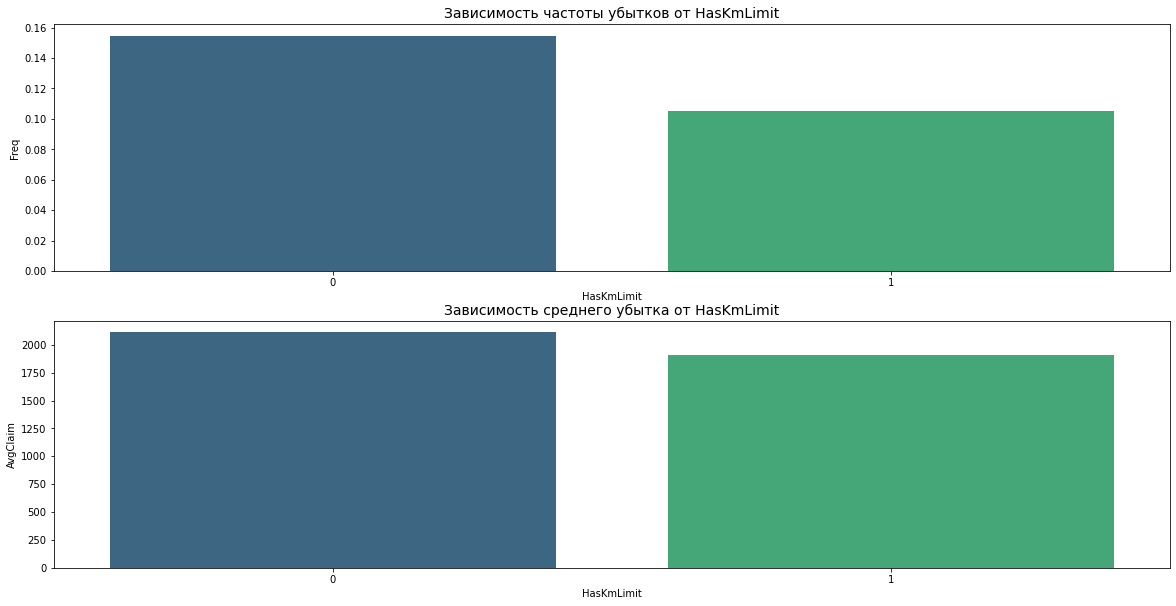

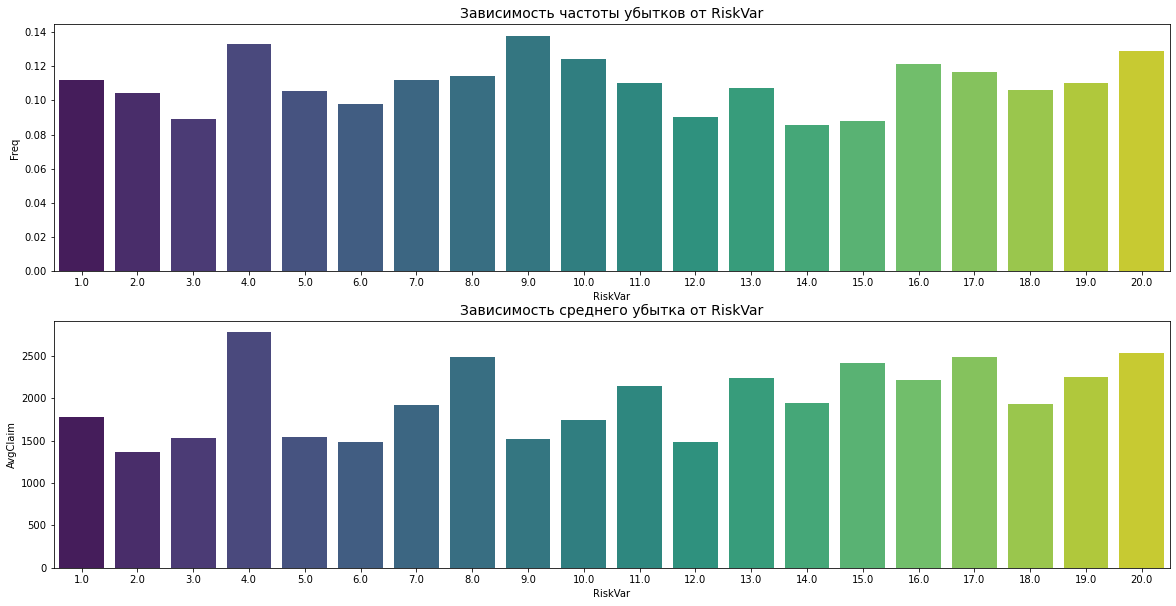

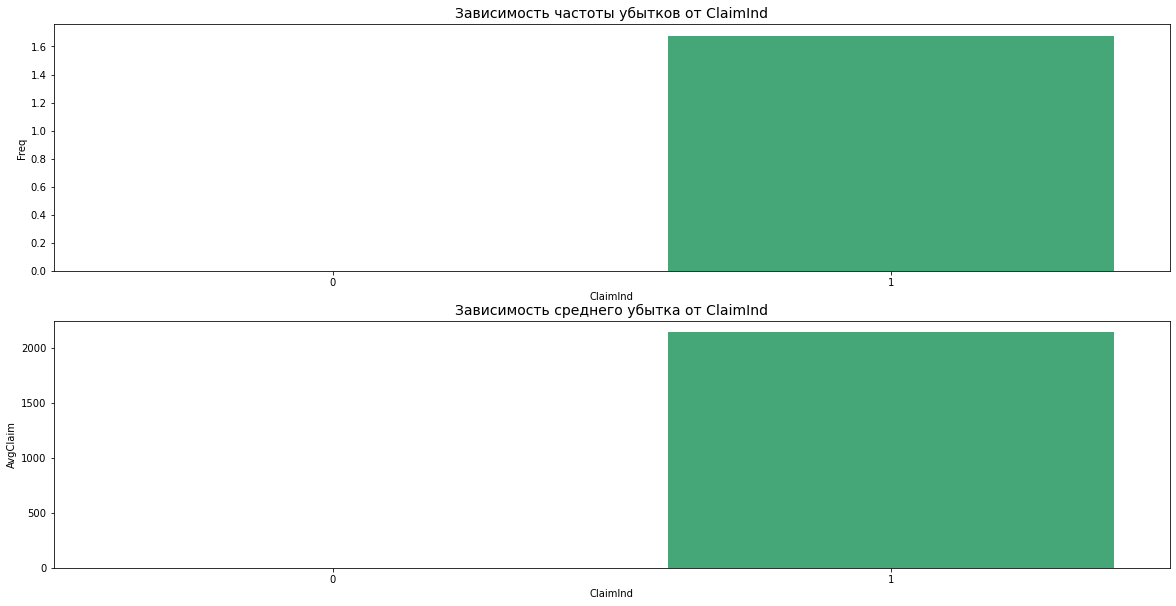

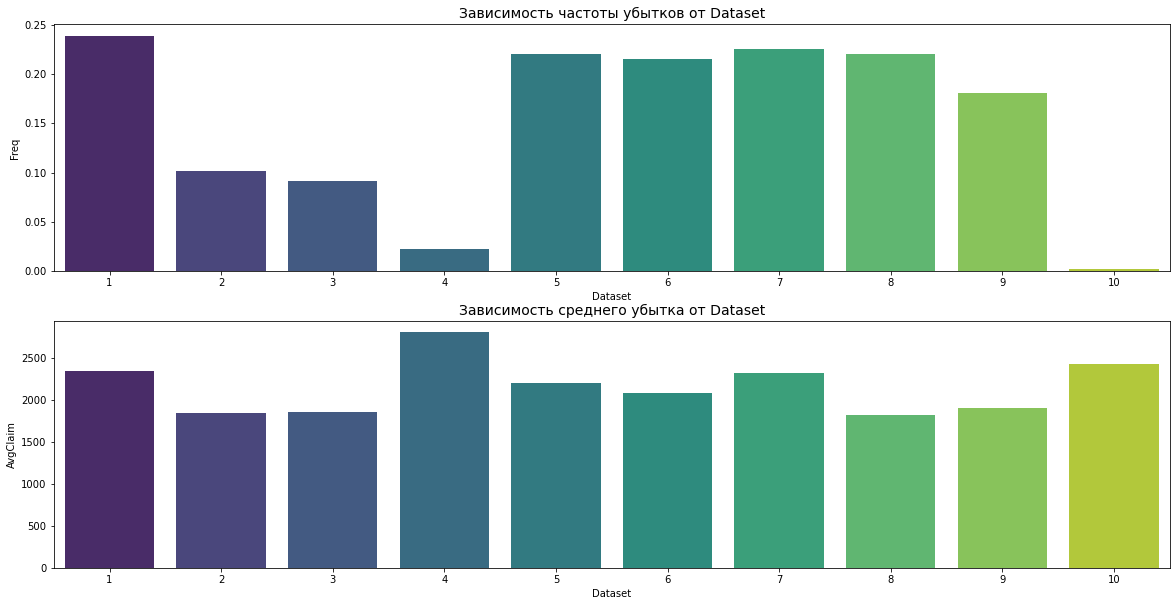

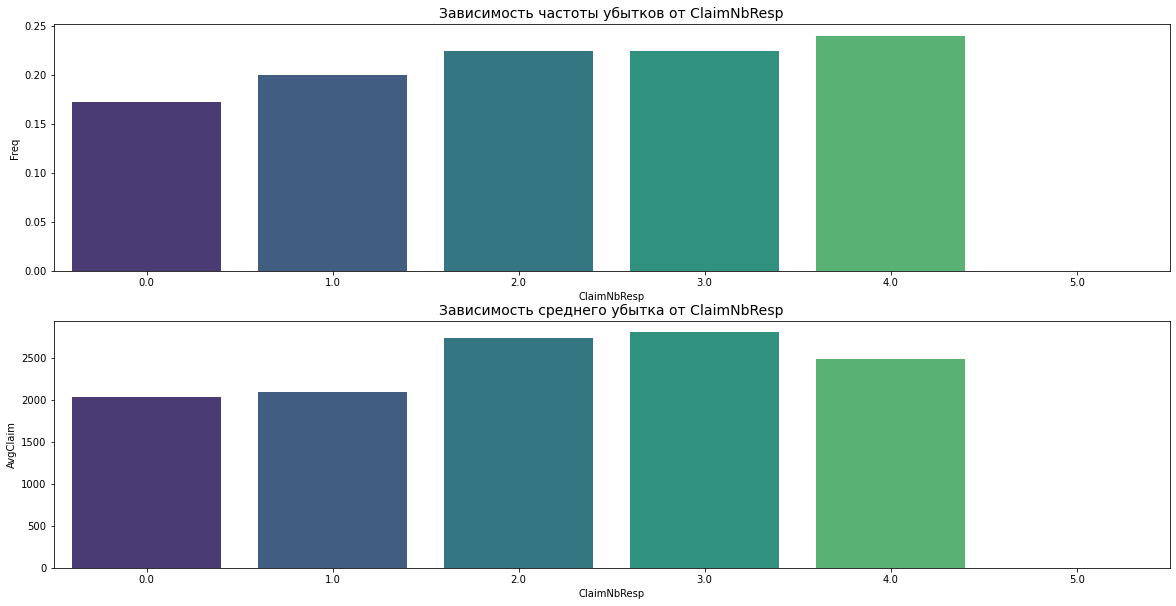

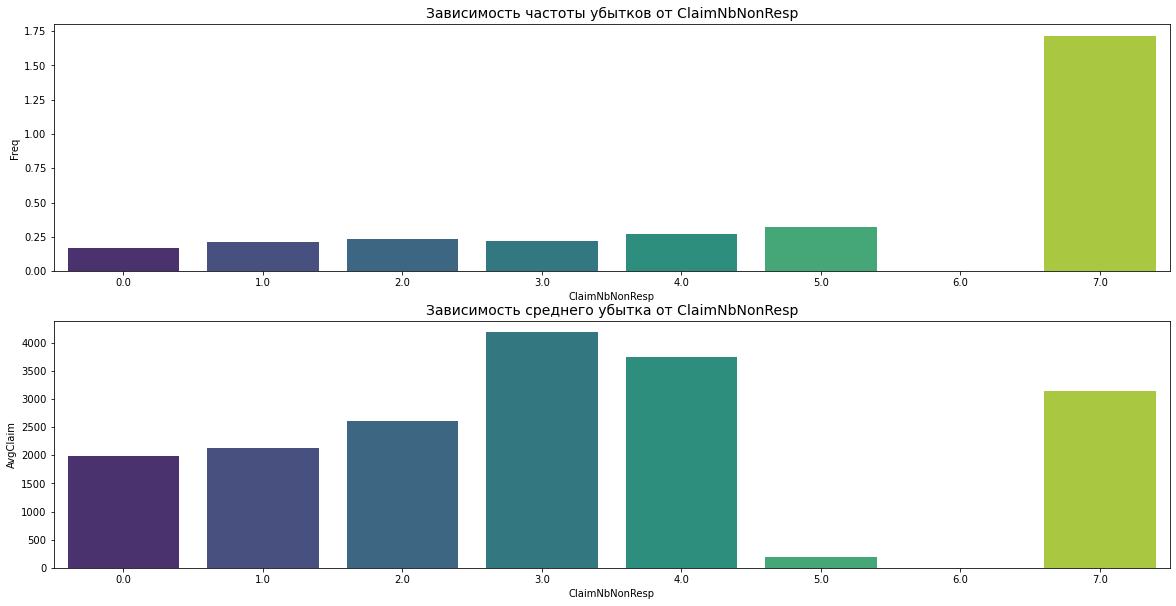

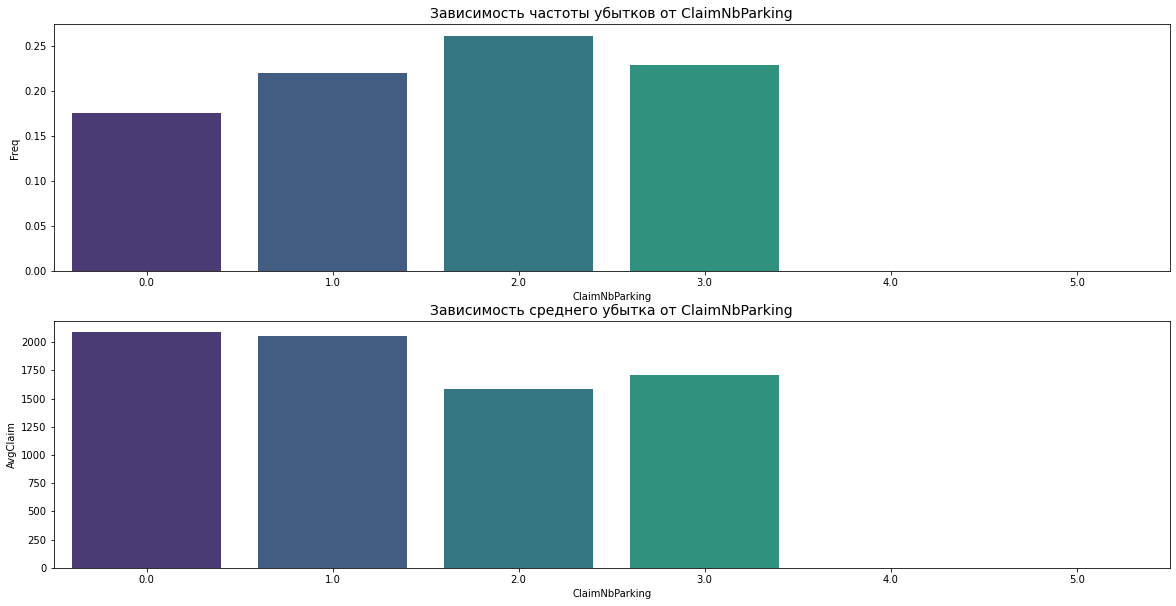

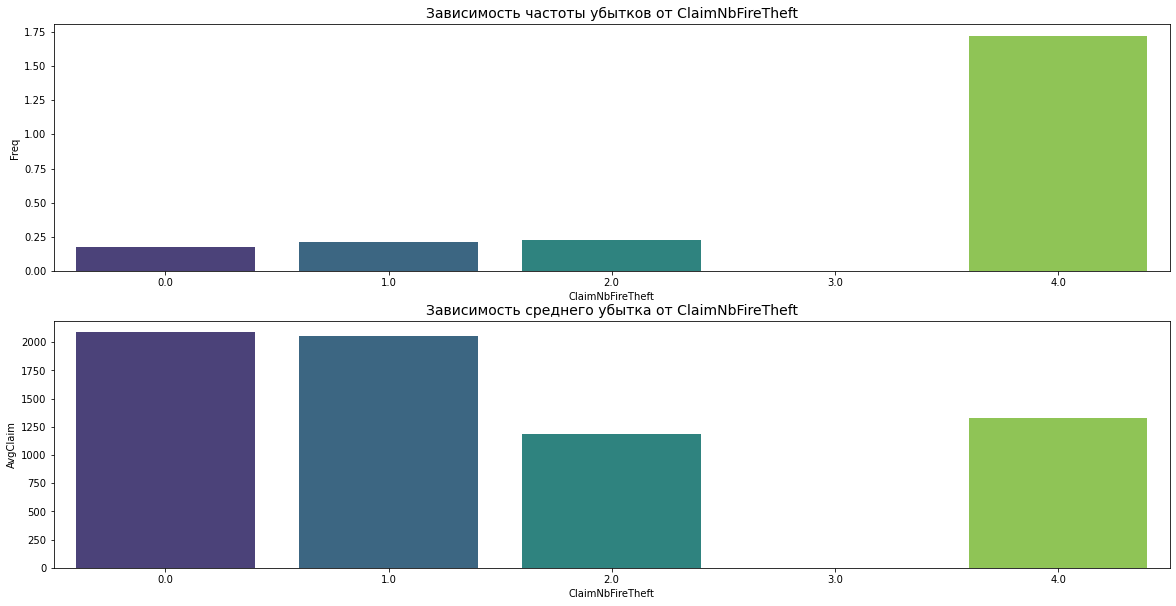

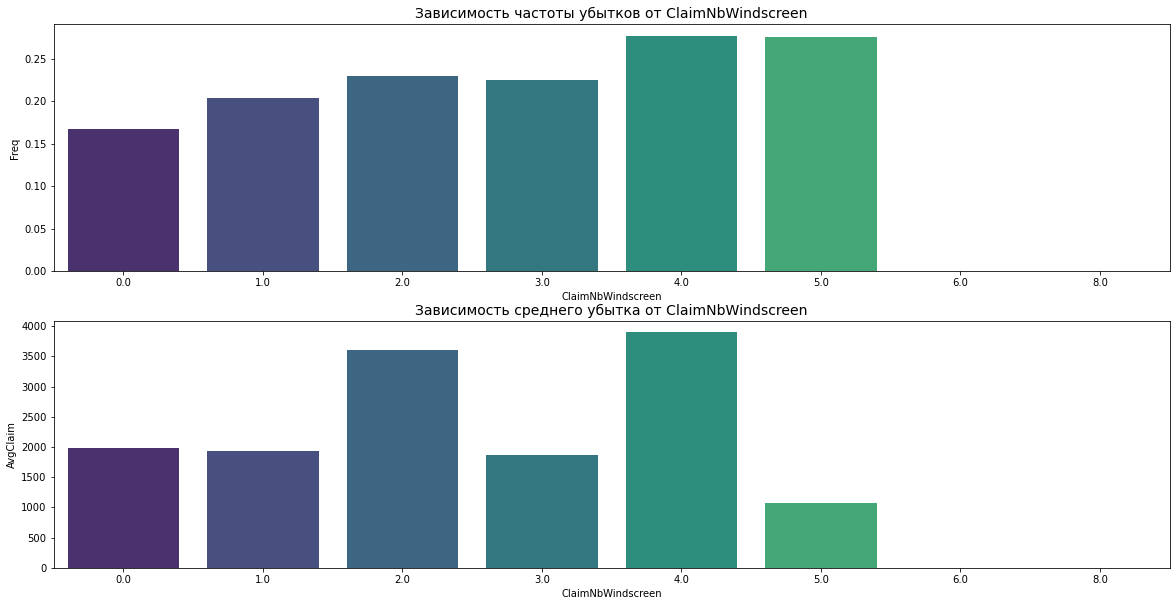

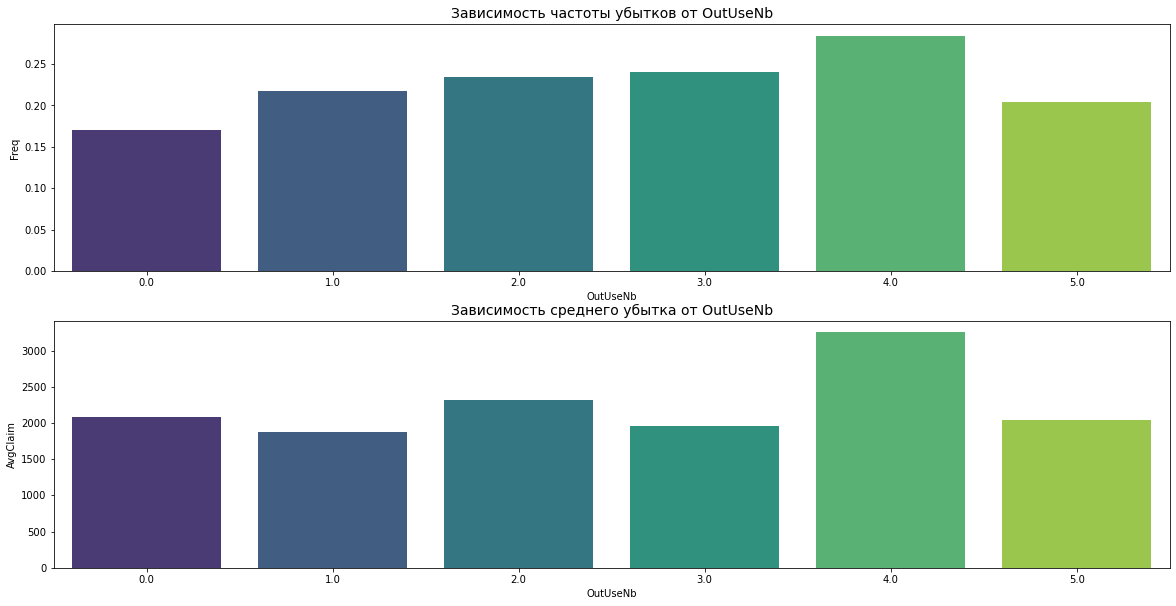

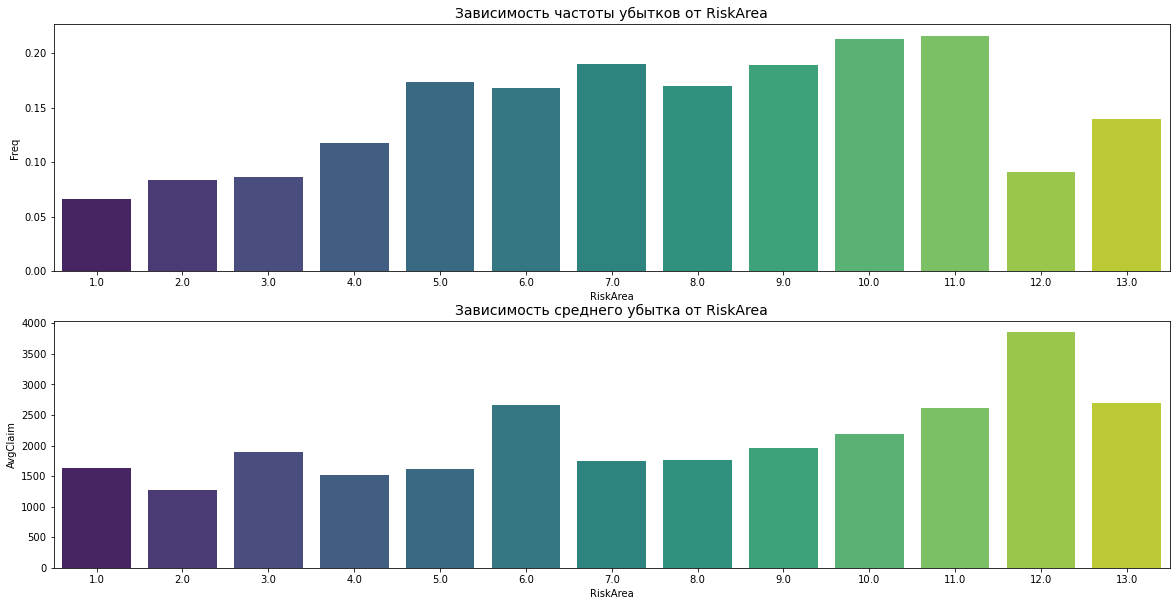

In [13]:
for var_name in DISCRETE_FEATURE_NAMES:    
    plot_dependencies(df, var_name)

#### Выводы:
* __HasKmLimit__ Признак HasKmLimit влияет как на частоту убытков, так и на средний убыток
* __RiskVar__ Признак RiskVar влияет на средний убыток
* __ClaimInd__ ClaimInd=1 означает наличие убытка, ClaimInd=0 - отсутствие убытка
* __Dataset__ Данные датасетах имеют разное распределение. В части частоты убытков, распределение данных в датасетах 2, 3, 4, 9 и 10 существенно отличается от распределения данных в датасетах 1, 5, 6, 7, 8. Средний убыток в датасетах также существенно отличается.
* __ClaimNbResp__ С увеличением значения признака ClaimNbResp увеличивается частота убытков. ClaimNbResp=5 практически не вствречается. Самыйй высокий средний убыток наблюдается при ClaimNbResp=3
* __ClaimNbNonResp__ Самая высокая частота убытков встречается при ClaimNbNonResp=7, самый высокий средний убыток - при ClaimNbNonResp=3. При ClaimNbNonResp=4 средний убыток снижается.
* __ClaimNbParking__ Самая высокая частота убытков встречается при ClaimNbParking=2, самый высокий средний убыток - при ClaimNbParking=0.
* __ClaimNbFireTheft__ Самая высокая частота убытков встречается при ClaimNbFireTheft=4, самый высокий средний убыток - при ClaimNbFireTheft=0.
* __ClaimNbWindscreen__ Частота убытков растет  с ClaimNbWindscreen=1 до ClaimNbWindscreen=4 и 5, самый высокий средний убыток - при ClaimNbWindscreen=4.
* __OutUseNb__ Частота убытков растет  с OutUseNb=1 до OutUseNb=4, при OutUseNb=5 - снижается. Самый высокий средний убыток - при OutUseNb=4.
* __RiskArea__ Частота убытков растет  с RiskArea=1 до RiskArea=11, затем снижается, точнее, ведет себя нестабильно. Средний убыток растет до RiskArea=12, потом снижается при RiskArea=13.

#### 2. Непрерывные признаки

In [14]:
CONTINUOUS_FEATURE_NAMES = []
for name in NUMERICAL_FEATURE_NAMES:
    if not name in DISCRETE_FEATURE_NAMES:
        CONTINUOUS_FEATURE_NAMES.append(name)
        
data[CONTINUOUS_FEATURE_NAMES].head()      

Exposure  BonusMalus  ClaimAmount
0     0.583          72     0.000000
1     0.200          80     0.000000
2     0.083          63     0.000000
3     0.375          63     0.000000
4     0.500          72  1418.610272

In [15]:
data[CONTINUOUS_FEATURE_NAMES].describe()

Exposure     BonusMalus    ClaimAmount
count  343080.000000  343080.000000  343080.000000
mean        0.441275      62.221590     137.777661
std         0.288110      17.466711    2401.187133
min         0.001000      50.000000   -3407.700000
25%         0.183000      50.000000       0.000000
50%         0.416000      50.000000       0.000000
75%         0.666000      72.000000       0.000000
max         1.000000     272.000000  802620.270997

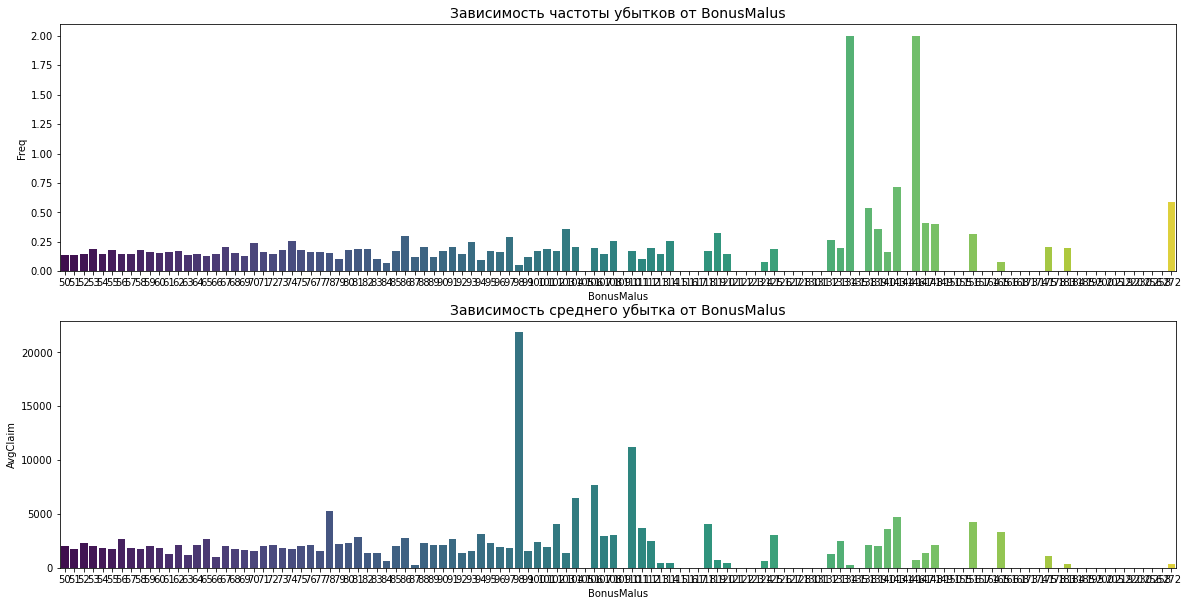

In [16]:
var_name = 'BonusMalus'
plot_dependencies(df, var_name)

### 2.3 Категориальные признаки

In [17]:
CATEGORICAL_FEATURE_NAMES = data[FEATURE_NAMES].select_dtypes(include=[np.object]).columns.to_list()
data[CATEGORICAL_FEATURE_NAMES].head()

VehAge                VehUsage         VehBody VehPrice  \
0      2            Professional           sedan       D    
1      0  Private+trip to office        microvan       K    
2      1            Professional  other microvan       L    
3      1            Professional  other microvan       L    
4      3            Professional             van       L    

                      VehEngine VehEnergy   VehMaxSpeed VehClass  \
0                     injection   regular  160-170 km/h        B   
1  direct injection overpowered    diesel  170-180 km/h       M1   
2  direct injection overpowered    diesel  170-180 km/h       M1   
3  direct injection overpowered    diesel  170-180 km/h       M1   
4  direct injection overpowered    diesel  140-150 km/h        0   

           Garage DeducType  
0            None       NaN  
1            None       NaN  
2            None       NaN  
3  Private garage       NaN  
4            None       NaN

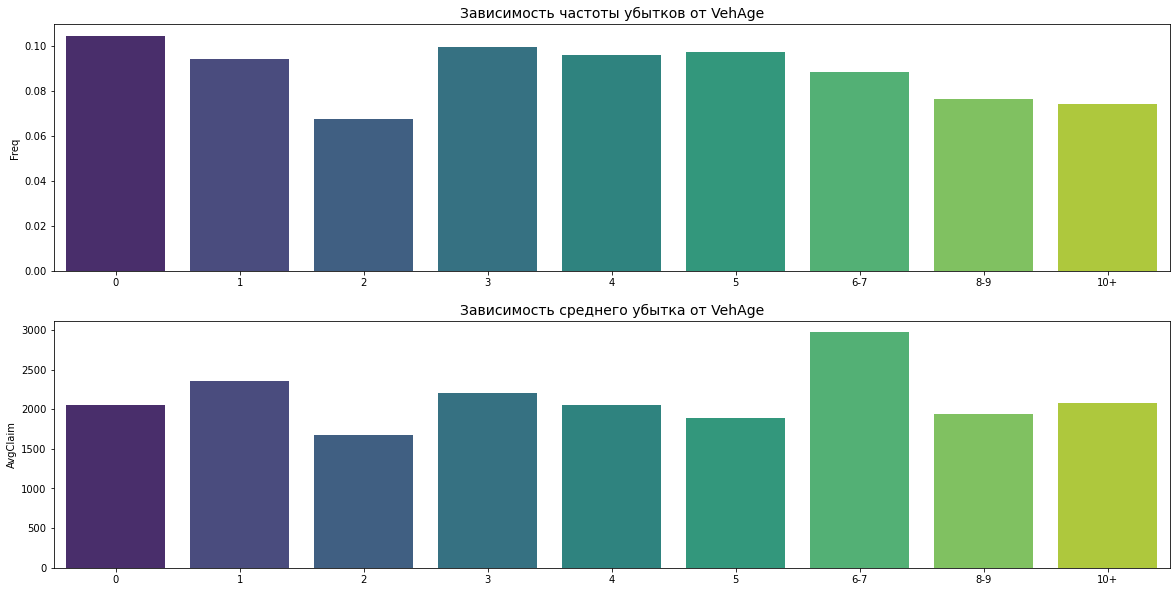

In [18]:
var_name = 'VehAge'
levels = ['0', '1', '2', '3', '4', '5', '6-7', '8-9', '10+']
plot_dependencies(df, var_name, levels=levels)

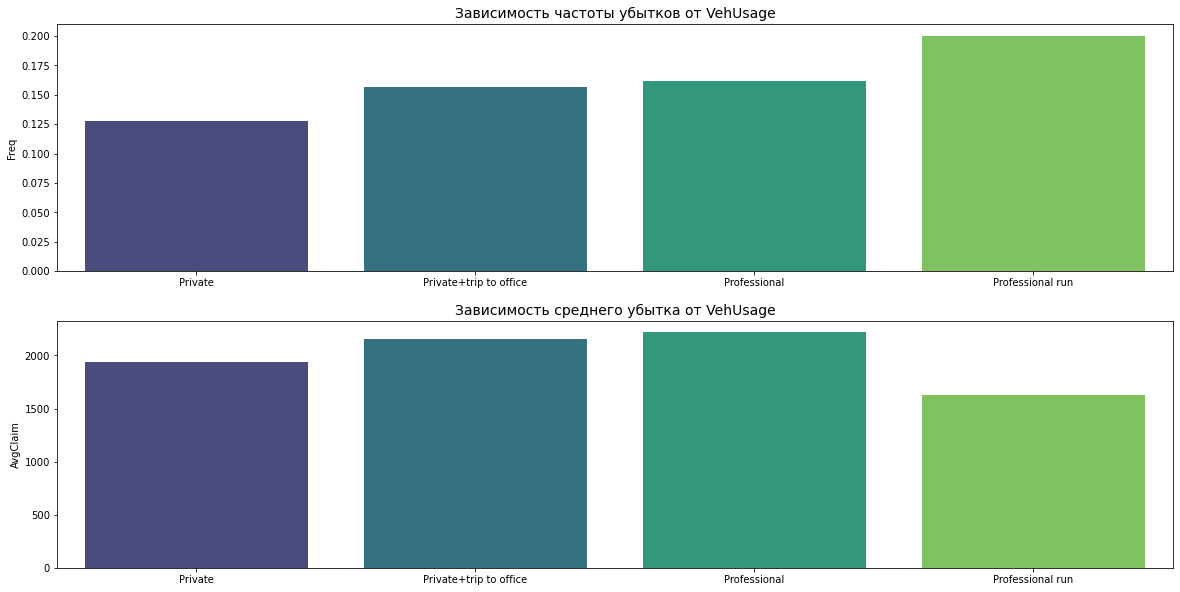

In [19]:
var_name = 'VehUsage'
levels = ['Private', 'Private+trip to office', 'Professional', 'Professional run']
plot_dependencies(df, var_name, levels=levels)

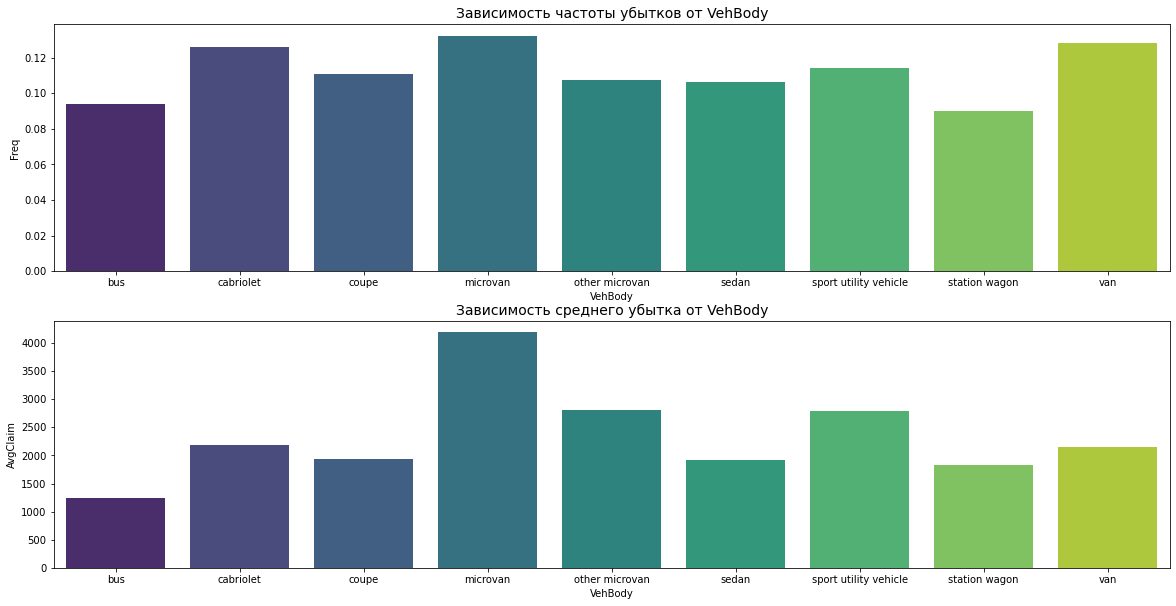

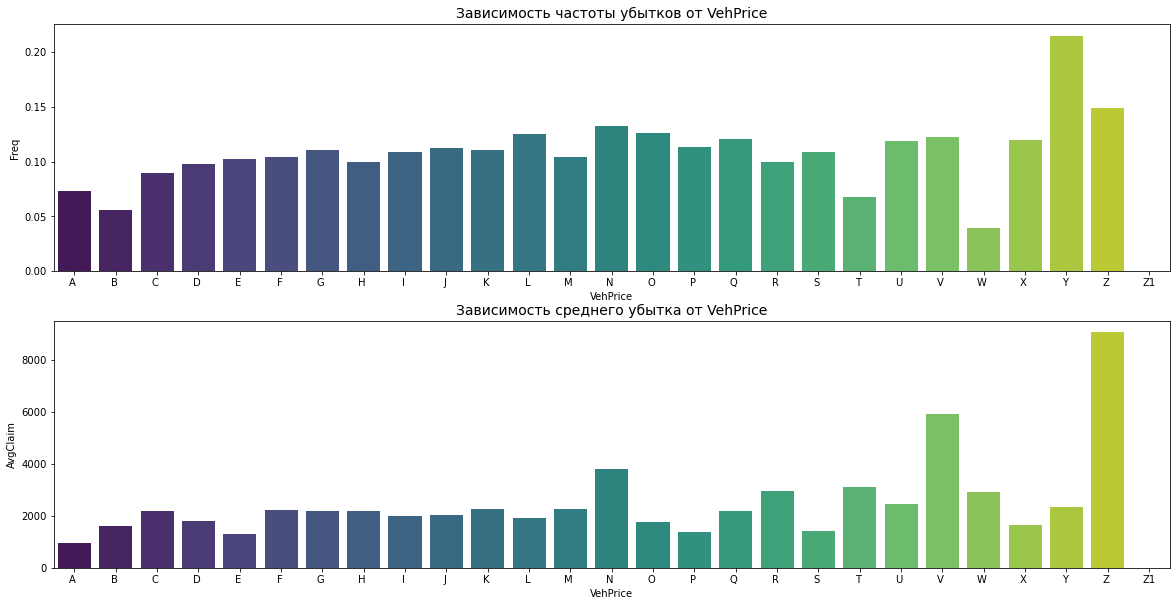

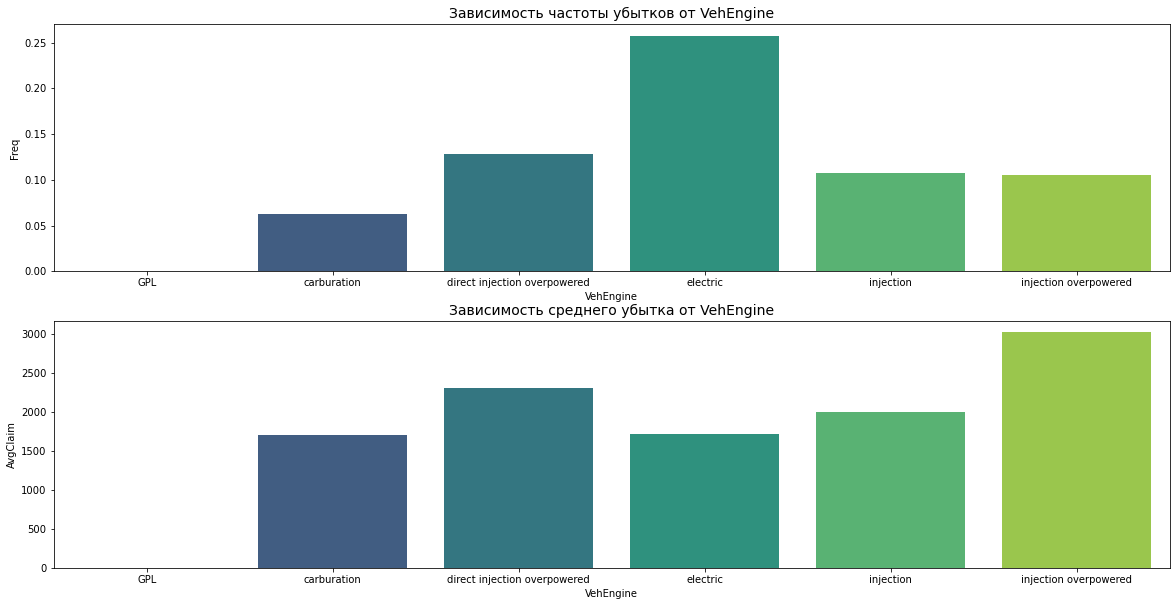

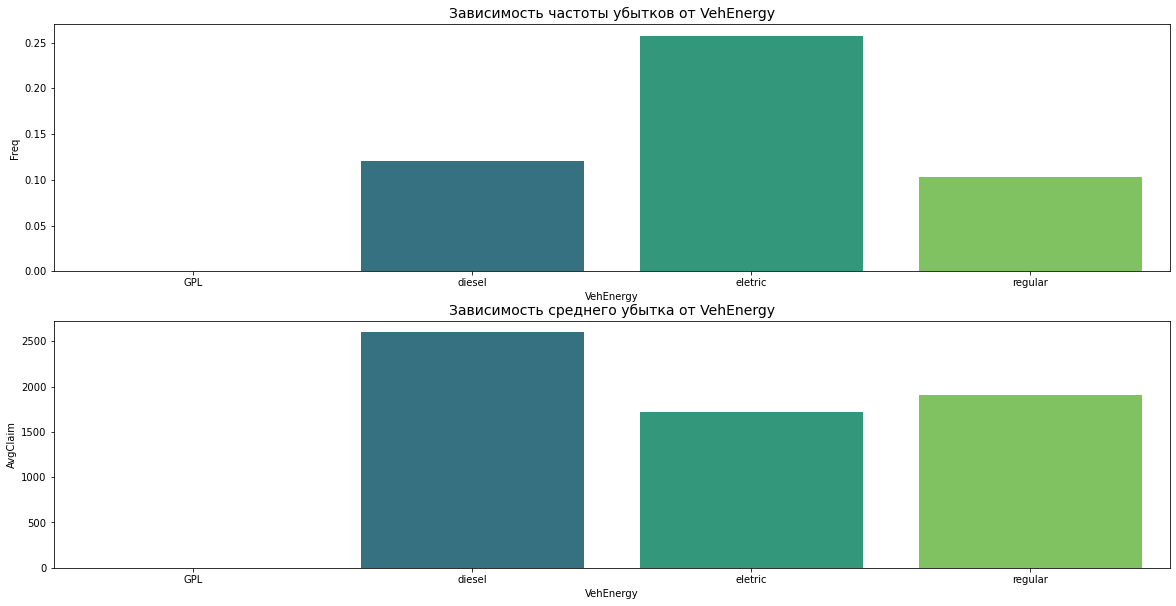

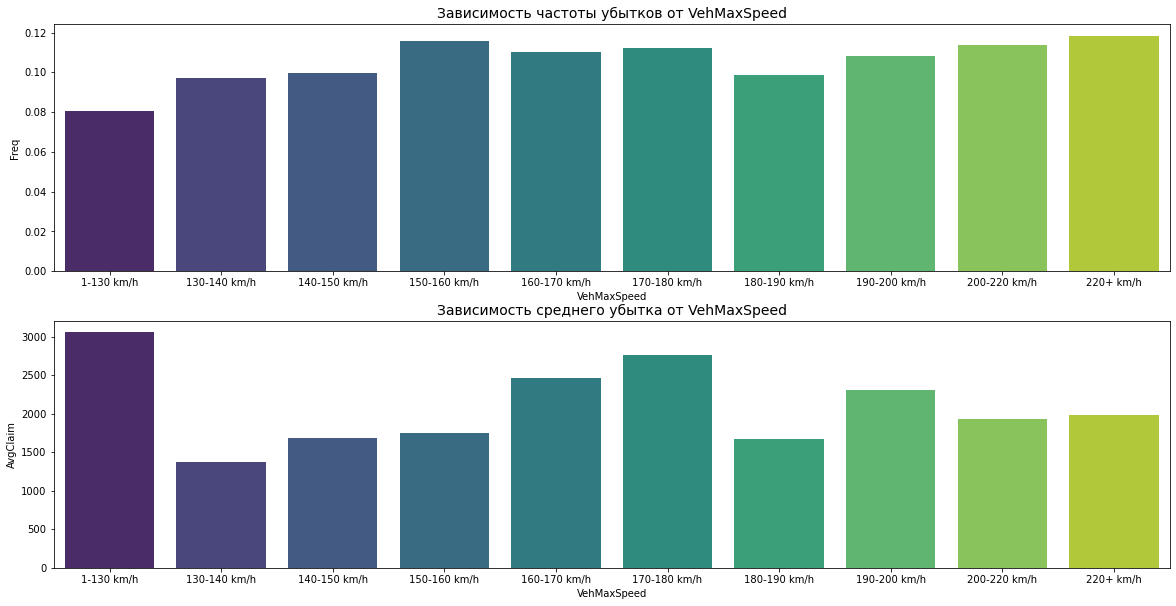

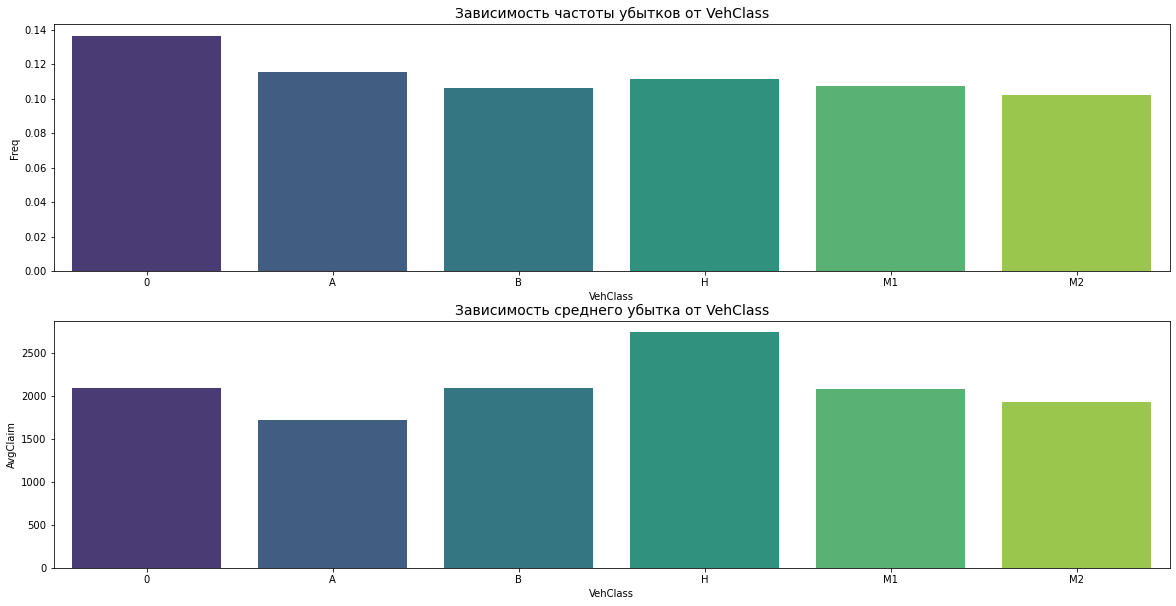

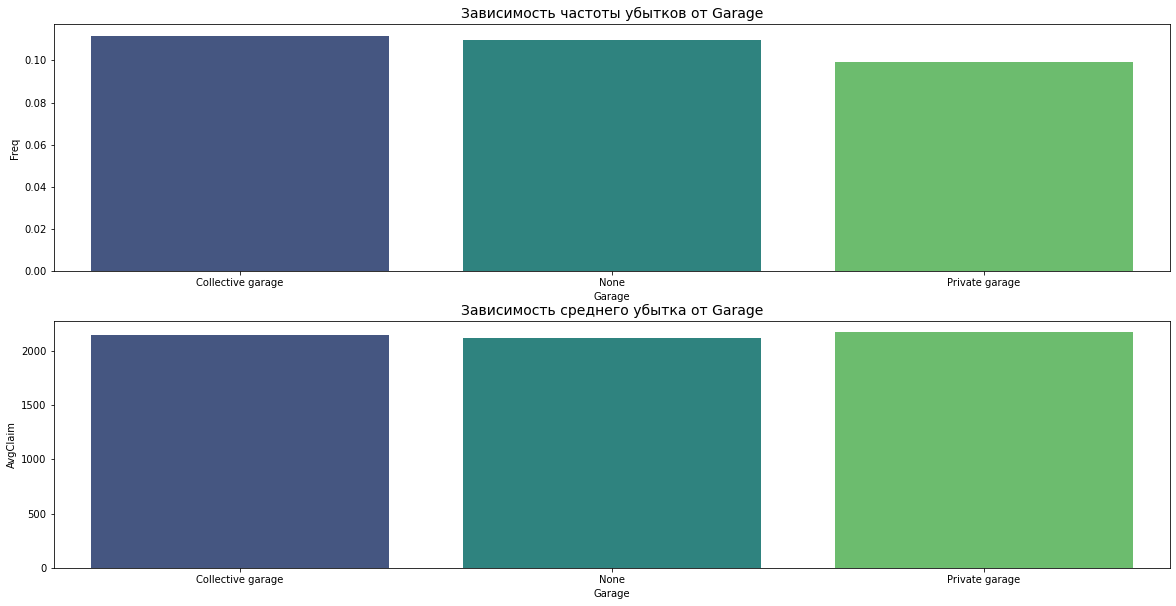

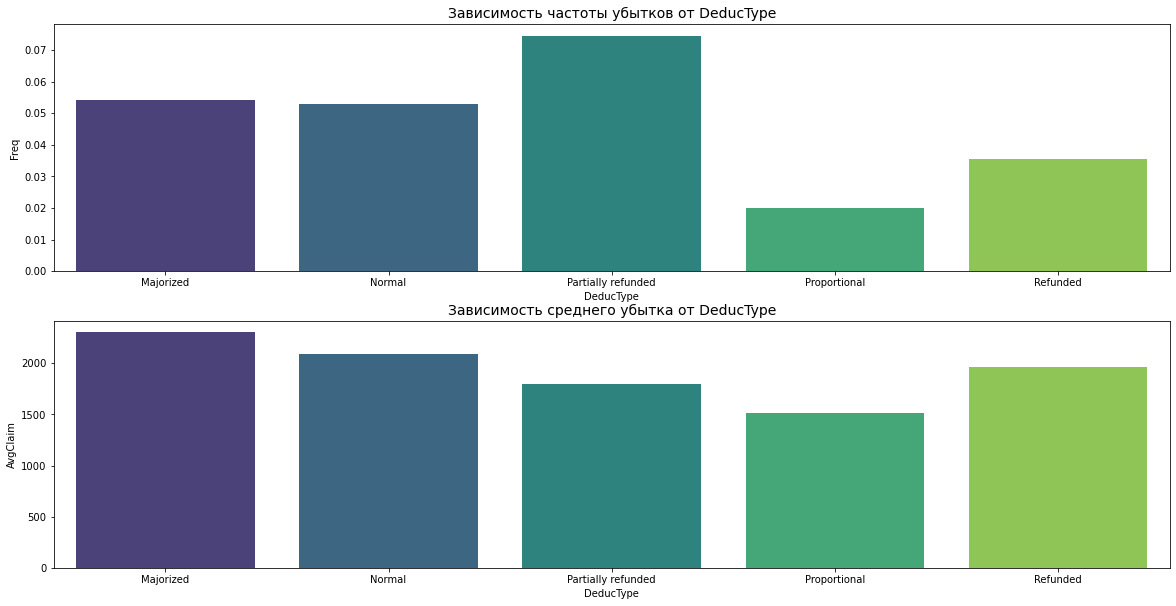

In [20]:
for var_name in CATEGORICAL_FEATURE_NAMES[2:]:
    plot_dependencies(df, var_name)

#### Выводы:
* __VehUsage__ Частота убытков растет по мере перехода от личного к профессиональному использлыванию: Private - Private+trip to office - Professional - Professional run, самый высокий средний убыток - при VehUsage=Professional.
* __VehBody__ Самая высокая частота убытков у VehBody=microvan, van. Cамый высокий средний убыток - при VehBody=microvan.
* __VehPrice__ Можно сказать, что частота убытков нарастает при продвижении VehPrice от A до Z. Самая высокая частота убытков у VehPrice=Y и Z. самый высокий средний убыток - при VehPrice=Z.
* __VehEngine__  Самая высокая частота убытков у VehEngine=electric. Cамый высокий средний убыток - при VehEngine=injection overpowered.
* __VehEnergy__ Самая высокая частота убытков у VehEnergy=electric. Cамый высокий средний убыток - при VehEnergy=diesel.
* __VehMaxSpeed__ Самая низкая частота убытков при VehMaxSpeed=1-130 km/h. При этом, самый высокий средний убыток - тоже при VehMaxSpeed=1-130 km/h
* __VehClass__ Самая высокая частота убытков у VehClass=0. Cамый высокий средний убыток - при VehClass=H.
* __Garage__ При Garage=Private garage частота убытков немного ниже, чем при отсутствии гаража и при Garage=Collective garage.
* __DeducType__ Самая высокая частота убытков у DeducType=Partially refunded DeductType. Cамый высокий средний убыток - при DeducType=Majorized.